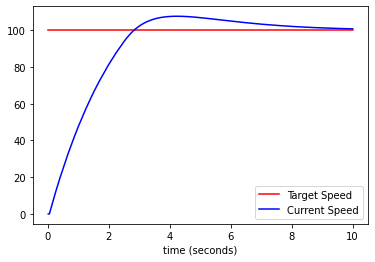

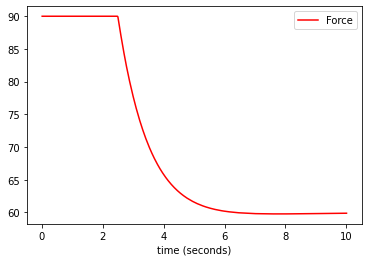

In [1]:
import sys
sys.path.append("../../")

from lib.data.dataplot import *
from lib.dds.dds import *
from lib.system.basic import *
from lib.utils.time import *

class SimpleSpeedControl:
    
    def __init__(self, _kp, _ki, _sat):
        self.P = Proportional(_kp)
        self.I = Integrator()
        self.ki = _ki
        self.saturation = _sat
        
    def evaluate(self, delta_t, error):
        out = self.P.evaluate(delta_t, error) + self.ki * self.I.evaluate(delta_t, error)
        if out > self.saturation:
            out = self.saturation
        if out < -self.saturation:
            out = -self.saturation
        return out
    

dp = DataPlotter()
dp.set_x("time (seconds)")
dp.add_y("target", "Target Speed")
dp.add_y("current", "Current Speed")

fp = DataPlotter()
fp.set_x("time (seconds)")
fp.add_y("force", "Force")

dds = DDS()
dds.start()
dds.subscribe(['speed'])

target_speed = 100.0
ctrl = SimpleSpeedControl(1.5, 0.7, 90)

t = Time()
t.start()
while t.get() < 10:
    
    current_speed = dds.wait('speed')
    delta_t = t.elapsed()
    
    error = target_speed - current_speed
    force = ctrl.evaluate(delta_t, error)
    
    dds.publish('force', force, DDS.DDS_TYPE_FLOAT)
    
    dp.append_x(t.get())
    dp.append_y("target", target_speed)
    dp.append_y("current", current_speed)
    
    fp.append_x(t.get())
    fp.append_y("force", force)


dds.publish('force', 0, DDS.DDS_TYPE_FLOAT)

dp.plot()
fp.plot()